In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from itertools import chain
from sklearn.preprocessing import minmax_scale
from scipy.stats import linregress, spearmanr, pearsonr
plt.rcParams['figure.figsize'] = [15, 10]
import warnings; warnings.simplefilter('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: mob_aba_energy.csv,lambdas_pmeans_output_mob.tsv, 10015CN83*annotations.txt, 10015CN84*annotations.txt,
# 10015CN85*annotations.txt,10015CN60*annotations.txt,lambdas_pmeans_output_STref.tsv, SRR*annotations.txt


Load definitions

In [3]:
def Extract(lst): 
    return list(next(zip(*lst))) 

def ftest(st_spec_cutoff,aba_spec_cutoff):
    bb_count = 0
    fisher_dict = {}
    pval_list = []

    for condition, df in st_spec_cutoff.groupby('condition_1'):

            regions_tmp = list(set(st_spec_cutoff['AAR1'].tolist()))
            regions = [x for x in regions_tmp if str(x) != 'nan']

            for i in regions:     
                for j in regions:

                    #SM-Omics genes
                    st_genes = df[df['AAR1'] == i]['gene_new'].tolist()

                    # ABA-genes
                    aba_genes = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] == j]['gene-symbol'].tolist()

                    # SM-Omics genes in all other regions
                    st_rest = df[df['AAR1'] != i]['gene_new'].tolist()

                    # ABA genes in all other regions
                    aba_rest = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] != j]['gene-symbol'].tolist()

                    # g1 = genes in both ST and ABA
                    # g2 = genes unique to ST
                    # g3 = genes unique to ABA
                    # g4 = genes neither in st or aba region but in the other regions

                    g1 = len(list(set(st_genes).intersection(aba_genes)))
                    g2 = len(list(set(aba_genes).difference(set(st_genes)))) 
                    g3 = len(list(set(st_genes).difference(set(aba_genes))))
                    g4 = len(list(set(st_rest).intersection(aba_rest)))

                    # Fisher's test
                    oddsratio, pvalue = stats.fisher_exact([[g4, g2], [g3, g1]], alternative='greater')

                    # Store pvalues in list to use for multiple corrections testing
                    pval_list.append(pvalue)

                    # Store fisher's test results in DF
                    ff = [condition, i, j, oddsratio, pvalue, g1]
                    # print(i, j, g1, g2, g3, g4, pvalue)

                    if bb_count == 0:
                        fisher_dict[bb_count] = ff

                        df_ff = pd.DataFrame.from_dict(fisher_dict)

                        df_ff['idx'] = ['condition', 'AAR_ST', 'AAR_ABA','Odds ratio', 'p value', 'Num shared genes']

                        df_ff.set_index('idx', inplace = True)

                        bb_count += 1
                    else:
                        df_ff[bb_count] = ff

                        bb_count += 1
    return pval_list, df_ff

def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

def Extract(lst): 
    return list(next(zip(*lst))) 

def rename_lambdas_index(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [4]:
# Load ABA ref files
path = '../../smomics_data/'
aba_spec = pd.read_csv(os.path.join(path, 'mob_aba_energy.csv'), index_col=0)


In [5]:
aba_spec

,aba-mean,region,aba-cv
Ctgf,2.800630,GR,0.561671
Ctgf,4.732470,OPL,0.494614
Ctgf,4.649930,MI,0.427079
Ctgf,5.476530,GL,0.550791
Camk4,2.064940,GR,1.248790
Camk4,1.337350,OPL,1.595860
Camk4,1.767920,MI,1.550200
Camk4,0.658374,GL,2.141770
Cbln4,1.205040,GR,0.781563
Cbln4,4.170870,OPL,0.360993


In [6]:
# Pick genes to correlate to SM-Omics signals per region
genes = ['Ctgf', 'Camk4', 'Lancl3', 'Cbln4', 'Nr2f2',]



In [7]:
# Load SM-Omics data for MOB

In [8]:
# Load Lambda pmean df
path = '../../smomics_data'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_output_mob.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [9]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [10]:
annot_path = '../../smomics_data'

annot_list = []

for stdata in list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns])):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)
annotdf = annotdf[annotdf['value'] != 'Unknown']
annotdf = annotdf[annotdf['value'].isin([i for i in annotdf['value'] if ";" not in i])]
annotdf['region'] = [i.split("(")[1].split(")")[0] for i in annotdf.value]
annotdf['region'] = annotdf['region'].replace({'GCL-D' : 'GR',
                                               'GCL-E' : 'GR',
                                               'M/T' : 'MI',
                                               'EPL' : 'OPL'})
annotdf = annotdf[annotdf['region'] != 'ONL']

In [11]:
list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns]))

['10015CN60_C2',
 '10015CN60_E2',
 '10015CN83_C1',
 '10015CN83_C2',
 '10015CN83_D1',
 '10015CN83_D2',
 '10015CN83_E1',
 '10015CN83_E2',
 '10015CN84_C1',
 '10015CN84_C2',
 '10015CN84_D1',
 '10015CN84_D2',
 '10015CN84_E2',
 '10015CN85_C1',
 '10015CN85_C2',
 '10015CN85_D1',
 '10015CN85_E1',
 '10015CN85_E2']

In [11]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'sm-omics'       

In [12]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in aba_spec.index:
        abs_gene = aba_spec.loc[gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('region')['aba-mean'].mean())).transform(lambda x: minmax_scale(x))['aba-mean']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('region')['aba-mean'].mean().index
aba_df['Condition'] = 'aba'

In [13]:
abs_gene

,aba-mean,region,aba-cv
Nr2f2,3.20389,GL,0.813932
Nr2f2,1.84235,GR,0.806774
Nr2f2,2.15753,OPL,0.900718
Nr2f2,2.49837,MI,0.557604


In [14]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'sm-omics']
corr_df['region'] = list(np.unique(abs_gene.groupby('region')['aba-mean'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('region')['aba-mean'].mean().index)]
corr_df = corr_df.fillna(0)

In [15]:
corr_df

,aba,sm-omics,region,gene
0,1.000000,1.000000,GL,Ctgf
1,0.000000,0.000000,GR,Ctgf
2,0.691095,0.335055,MI,Ctgf
3,0.721940,0.429472,OPL,Ctgf
4,0.000000,0.000000,GL,Camk4
5,1.000000,1.000000,GR,Camk4
6,0.788833,0.110165,MI,Camk4
7,0.482719,0.120475,OPL,Camk4
8,0.105574,0.420569,GL,Lancl3
9,0.000000,0.000000,GR,Lancl3


Ctgf
Spearman's r: 1.0
Spearman's p value: 0.0
Camk4
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Lancl3
Spearman's r: 1.0
Spearman's p value: 0.0
Cbln4
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Nr2f2
Spearman's r: 0.4
Spearman's p value: 0.6


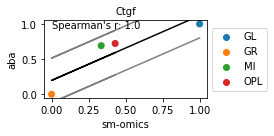

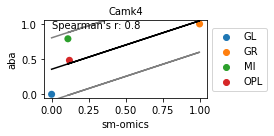

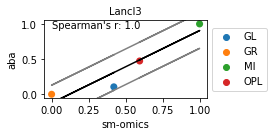

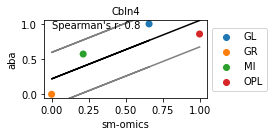

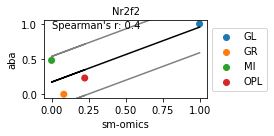

In [16]:
for gene in genes:
    
    # initialize a figure
    fig, ax = plt.subplots(figsize=(4, 2))

    x = 'sm-omics'
    y = 'aba'
    hue = 'region'
    corr_df_sub = corr_df[corr_df['gene'] == gene]

    sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=10)
    ax.set_title(gene, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    #plt.savefig("IFvsGENE_Neun.pdf", transparent=True, bbox_inches = 'tight',
    #    pad_inches = 0, dpi=1200, rasterized=True)

Spearman's r: 0.845
Spearman's p value: 2.771350306902571e-06


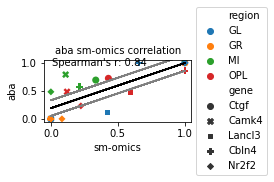

In [17]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))

x = 'sm-omics'
y = 'aba'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, style=style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba sm-omics correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_sm_all_genes_correlation.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

In [18]:
# Repeat correlations for SM-Omics and ST bs aba on different genes foudn in both 

In [19]:
# Pick genes to correlate to SM-Omics signals per region
genes = ['Nrsn1', 'Nos1ap', 'Cdh23', 'Prss12',]

In [20]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'sm-omics'       

In [21]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in aba_spec.index:
        abs_gene = aba_spec.loc[gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('region')['aba-mean'].mean())).transform(lambda x: minmax_scale(x))['aba-mean']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('region')['aba-mean'].mean().index
aba_df['Condition'] = 'aba'

In [22]:
abs_gene

,aba-mean,region,aba-cv
Prss12,4.419090,GL,0.557312
Prss12,0.993521,GR,1.182020
Prss12,3.524590,OPL,0.692523
Prss12,2.550570,MI,0.781738


In [23]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'sm-omics']
corr_df['region'] = list(np.unique(abs_gene.groupby('region')['aba-mean'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('region')['aba-mean'].mean().index)]
corr_df = corr_df.fillna(0)

Nrsn1
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Nos1ap
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Cdh23
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Prss12
Spearman's r: 1.0
Spearman's p value: 0.0


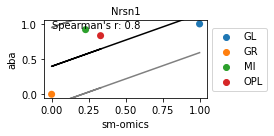

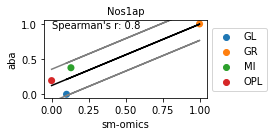

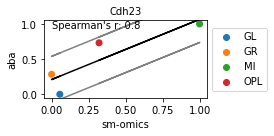

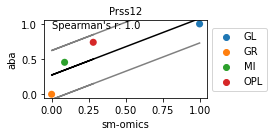

In [24]:
for gene in genes:
    
    # initialize a figure
    fig, ax = plt.subplots(figsize=(4, 2))

    x = 'sm-omics'
    y = 'aba'
    hue = 'region'
    corr_df_sub = corr_df[corr_df['gene'] == gene]

    sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=10)
    ax.set_title(gene, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    #plt.savefig("IFvsGENE_Neun.pdf", transparent=True, bbox_inches = 'tight',
    #    pad_inches = 0, dpi=1200, rasterized=True)

Spearman's r: 0.902
Spearman's p value: 1.7789965823306303e-06


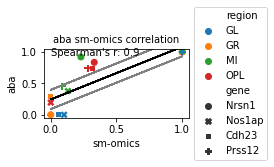

In [25]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))

x = 'sm-omics'
y = 'aba'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, style=style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba sm-omics correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_sm_st_genes_correlation.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)

In [26]:
# Load ST data for MOB

In [27]:
# Load Lambda pmean df
path = '../../smomics_data'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_output_STref.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [28]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [55]:
annot_path = '../../smomics_data'

annot_list = []

for stdata in list(np.unique([i[0].split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in lambda_posterior_means.columns])):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)
annotdf = annotdf[annotdf['value'] != 'Unknown']
annotdf = annotdf[annotdf['value'].isin([i for i in annotdf['value'] if ";" not in i])]
annotdf['region'] = [i.split("(")[1].split(")")[0] for i in annotdf.value]
annotdf['region'] = annotdf['region'].replace({'GCL-D' : 'GR',
                                               'GCL-E' : 'GR',
                                               'M/T' : 'MI',
                                               'EPL' : 'OPL',
                                              'E':'GR',
                                              'RMS':'GR',
                                              'GCL-I':'GR'})
annotdf = annotdf[annotdf['region'] != 'ONL']

In [56]:
annotdf['image'] = annotdf['image'].replace({'Rep1' : 'SRR3382371',
                          'Rep2' : 'SRR3382372',
                          'Rep3' : 'SRR3382383',
                          'Rep4' : 'SRR3382384',
                          'Rep5' : 'SRR3382385',
                          'Rep6' : 'SRR3382386',
                          'Rep7' : 'SRR3382387',
                          'Rep8' : 'SRR3382388',
                          'Rep9' : 'SRR3382389',
                          'Rep10' : 'SRR3382390',
                          'Rep11' : 'SRR3382373', 
                          'Rep12' : 'SRR3382374', })
                          

In [57]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'st'       

In [58]:
sm_df

,Nrsn1,Nos1ap,Cdh23,Prss12,Condition
region,,,,,
GL,1.000000,0.000000,0.222987,1.000000,st
GR,0.000000,1.000000,0.000000,0.066252,st
IPL,0.186834,0.277250,0.300922,0.000000,st
OPL,0.341033,0.065391,1.000000,0.222507,st


In [59]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in aba_spec.index:
        abs_gene = aba_spec.loc[gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('region')['aba-mean'].mean())).transform(lambda x: minmax_scale(x))['aba-mean']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('region')['aba-mean'].mean().index
aba_df['Condition'] = 'aba'

In [60]:
aba_df

,Nrsn1,Nos1ap,Cdh23,Prss12,Condition
region,,,,,
GL,1.000000,0.000000,0.000000,1.000000,aba
GR,0.000000,1.000000,0.283672,0.000000,aba
MI,0.918731,0.377263,1.000000,0.454537,aba
OPL,0.832895,0.194428,0.731715,0.738875,aba


In [61]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'st']
corr_df['region'] = list(np.unique(abs_gene.groupby('region')['aba-mean'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('region')['aba-mean'].mean().index)]
corr_df = corr_df.fillna(0)

Nrsn1
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007
Nos1ap
Spearman's r: 1.0
Spearman's p value: 0.0
Cdh23
Spearman's r: 0.6
Spearman's p value: 0.3999999999999999
Prss12
Spearman's r: 0.8
Spearman's p value: 0.20000000000000007


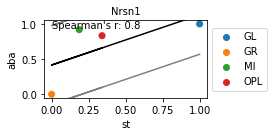

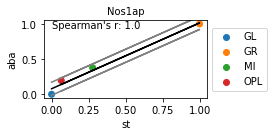

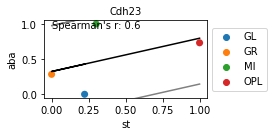

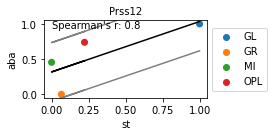

In [62]:
for gene in genes:
    
    # initialize a figure
    fig, ax = plt.subplots(figsize=(4, 2))

    x = 'st'
    y = 'aba'
    hue = 'region'
    corr_df_sub = corr_df[corr_df['gene'] == gene]

    sns.scatterplot(x=x, y=y, hue=hue, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=10)
    ax.set_title(gene, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()



Spearman's r: 0.706
Spearman's p value: 0.002227452008144441


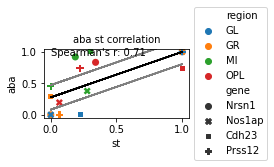

In [65]:
# initialize a figure
fig, ax = plt.subplots(figsize=(4, 2))

x = 'st'
y = 'aba'
hue = 'region'
style = 'gene'
corr_df_sub = corr_df

sns.scatterplot(x=x, y=y, hue=hue, style=style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
ax.set_title('aba st correlation', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("../../figures/aba_st_genes_correlation.pdf", transparent=True, bbox_inches = 'tight',
   pad_inches = 0, dpi=1200, rasterized=True)